### 5. Image Localization

This notebook builds on the previous notebook (classification) and attaches a regression head to the model for localization.

In [6]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import os
import time
%matplotlib inline

In [7]:
data = pickle.load(open("/home/marcchan/Traffic/traffic_image_detection/working_data/working_set.p","rb"))
train_data = data["train_data"]
train_labels = data["train_labels"]
val_data = data["val_data"]
val_labels = data["val_labels"]
del data

In [8]:
#Define functions to zero-center data and convert zero-centered data back to RGB 255 values
def zero_center(data):
    data = (data.astype(np.float32)-(255/2))/(255/2)
    return data

def zero_to_rgb(data):
    data = (data*(255/2)+(255/2)).astype(np.uint8)
    return data

In [9]:
#zero center the data
train_data = zero_center(train_data)
val_data = zero_center(val_data)

In [10]:
#Setting up evaluation metrics used to assess the classifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

#Setting up IOU metrics
def IOU(y_true,y_pred,y_bb,y_pred_bb):
    y_true = np.reshape(y_true,(-1,1))
    y_pred = np.reshape(y_pred,(-1,1))
    y_bb = np.reshape(y_bb,(-1,4))
    y_pred_bb = np.reshape(y_pred_bb,(-1,4))
    mask = (y_true==1)*(y_pred==1)
    iou = []
    
    for i, (t, p) in enumerate(zip(y_bb,y_pred_bb)):
        #convert width and height back to linear values
        tx, ty, tw, th = t
        px, py, pw, ph = p
        
        tw = tw**2
        th = th**2
        pw = pw**2
        ph = ph**2
        
        #If there is no object present/detected, IOU = -1 as indicator
        if not mask[i]:
            iou.append(-1)
            continue
        
        #If bounding boxes do not intersect, IOU = 0
        case_1 = ((tx-tw/2)>=(px+pw/2))or((ty-th/2)>=(py+ph/2))
        case_2 = ((tx+tw/2)<=(px-pw/2))or((ty+th/2)<=(py-ph/2))
        if case_1 or case_2:
            iou.append(0)
            continue
            
        #Calculate intersection
        bb_tlX = max(tx-tw/2,px-pw/2)
        bb_tlY = max(ty-th/2,py-ph/2)
        bb_brX = min(tx+tw/2,px+pw/2)
        bb_brY = min(ty+th/2,py+ph/2)
        assert bb_brX>bb_tlX, "X value of bounding box invalid"
        assert bb_brY>bb_tlY, "Y value of bounding box invalid"
        intsec = (bb_brX-bb_tlX)*(bb_brY-bb_tlY)
        assert intsec > 0, "Invalid value encountered when calculating intersection"
        
        #Calculate union
        union = (tw*th)+(pw*ph)-intsec
        assert union > 0, "Invalid value encountered when calculating union"
        iou.append(intsec/union)

    assert len(iou) == len(y_true), "IOU results incomplete"
    return np.array(iou)

def metrics(y_true,y_pred_proba,y_bb,y_pred_bb):
    y_pred = np.argmax(y_pred_proba,axis=-1)
    iou = IOU(y_true,y_pred,y_bb,y_pred_bb)
    mean_iou = np.mean(iou[iou>=0])
    cm = confusion_matrix(y_true,y_pred)
    true_negative = cm[0,0]
    false_positive = cm[0,1]
    false_negative = cm[1,0]
    true_positive = cm[1,1]
    recall = true_positive/(true_positive+false_negative)
    precision = true_positive/(true_positive+false_positive)
    accuracy = sum(y_true == y_pred)/y_true.shape[0]
    auc = roc_auc_score(y_true,y_pred_proba[:,1])
    print("IOU: {0:.2f}, Accuracy: {1:.2f}, AUC:{2:.2f}, Precision: {3:.2f}, Recall: {4:.2f}".format(mean_iou,accuracy,auc,precision,recall))

In [11]:
#Function to assist in plotting bounding boxes and labels
def plot_traffic(data,p_bb,p_label=None,cols=3, plot_gt=False, gt_bb=None, gt_label=None):
    #Code to to configure display of images in a x by cols grid
    if data.shape[0] < cols:
        cols = data.shape[0]
    if data.shape[0]%cols == 0:
        rows = data.shape[0]//cols
    else:
        rows = (data.shape[0]//cols)+1
    fig, axarr = plt.subplots(nrows=rows,ncols=cols,sharex=True,sharey=True,figsize=(18,rows*6))
    axarr = np.reshape(axarr,-1)
    
    #Code to display images and draw bounding boxes
    for i, d in enumerate(data):
        axarr[i].imshow(zero_to_rgb(d))
        im_w = d.shape[0]
        im_h = d.shape[1]
        x = p_bb[i,0]*im_w
        y = p_bb[i,1]*im_h
        w = int(np.square(p_bb[i,2])*im_w)
        h = int(np.square(p_bb[i,3])*im_h)
        tlX = int(x-(w/2))
        tlY = int(y-(h/2))
        annotation = ""
        try:
            annotation = annotation+"Vehicle Present: {}".format(p_label[i]==1)
        except:
            pass
        
        try:
            if p_label[i]==1:
                rect = patches.Rectangle((tlX,tlY),w,h,linewidth=1,edgecolor='r',facecolor='none')
                axarr[i].add_patch(rect)
        except:
            rect = patches.Rectangle((tlX,tlY),w,h,linewidth=1,edgecolor='r',facecolor='none')
            axarr[i].add_patch(rect)
        if plot_gt:
            iou = IOU(gt_label[i],p_label[i],gt_bb[i], p_bb[i])[0]
            if iou >= 0:
                annotation = annotation +", IOU: {0:.2f} ".format(iou)
            axarr[i].text(0.05,0.95,annotation,fontsize=12,color="white", transform=axarr[i].transAxes)
            gt_x = gt_bb[i,0]*im_w
            gt_y = gt_bb[i,1]*im_h
            gt_w = int(np.square(gt_bb[i,2])*im_w)
            gt_h = int(np.square(gt_bb[i,3])*im_h)
            gt_tlX = int(gt_x-(gt_w/2))
            gt_tlY = int(gt_y-(gt_h/2))
            rect_t = patches.Rectangle((gt_tlX,gt_tlY),gt_w,gt_h,linewidth=1,edgecolor='b',facecolor='none')
            axarr[i].add_patch(rect_t)
    plt.show()

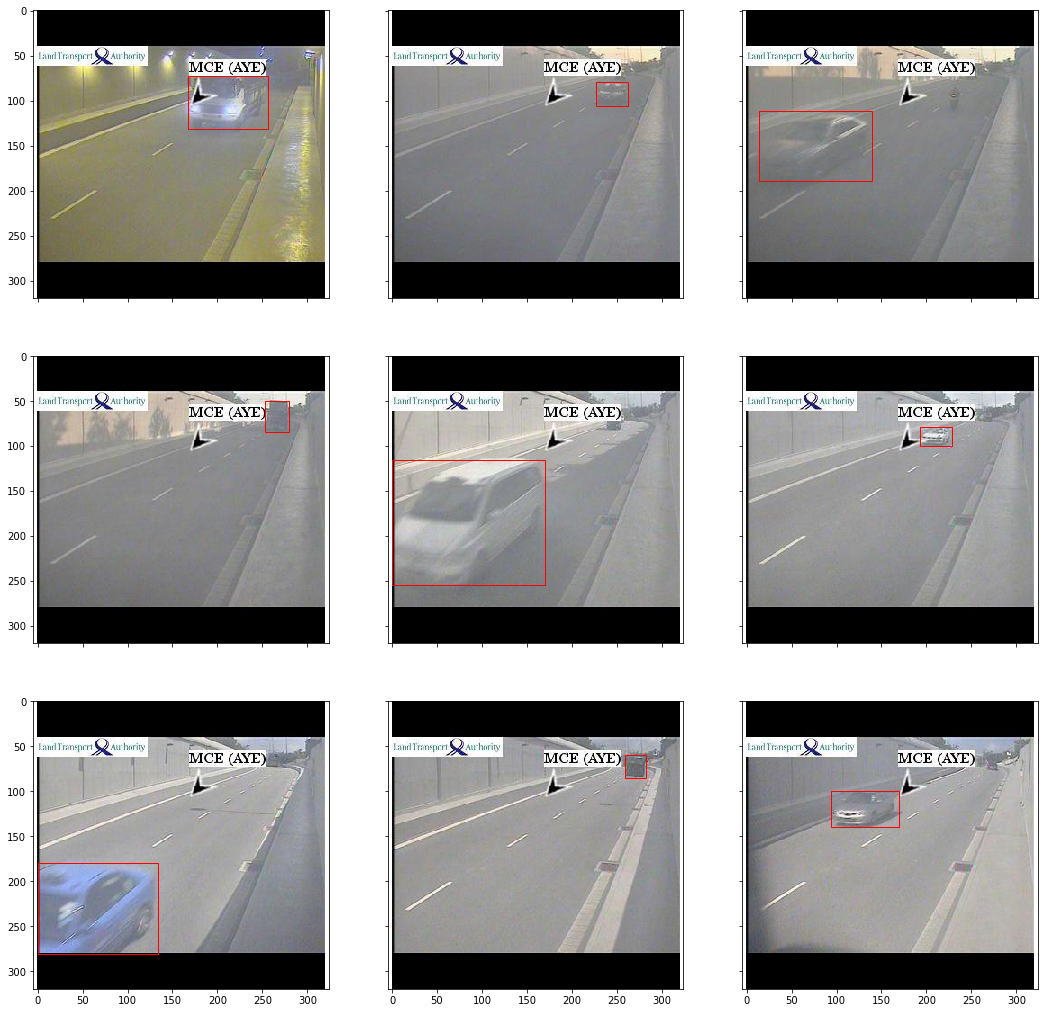

In [12]:
#Plot some images with the localization labels 
plot_traffic(train_data[0:9],train_labels[0:9,1:])

In [8]:
num_labels = 2
#convert class_labels to 1-hot
hot_train_labels = (np.arange(num_labels) == train_labels[:,0][:,None]).astype(np.float32)
hot_val_labels = (np.arange(num_labels) == val_labels[:,0][:,None]).astype(np.float32)

In [9]:
#set up bounding box ground truth labels
train_reg_labels = train_labels[:,1:].astype(np.float32)
val_reg_labels = val_labels[:,1:].astype(np.float32)

In [72]:
###Building Blocks of the CNN
def conv2d_relu(data,stride,filter_size,output_channels,name,train=True,xv=True):
    with tf.variable_scope(str(name)):
        input_shape = data.get_shape().as_list()
        conv_shape = [filter_size,filter_size,input_shape[-1],output_channels]
        strides = [1,stride,stride,1]
        if train:
            if xv:
                ##Use kaiming-he gaussian initializer, cap at 0.1 for better training
                xv_init = min(np.sqrt(2./(filter_size*filter_size*input_shape[-1])),0.1)
            else:
                xv_init = 0.01
            print(xv_init)
            ##Set up convolution weights and bias
            weights = tf.Variable(tf.truncated_normal(conv_shape,stddev=xv_init),name="weights")
            #bias = tf.Variable(tf.zeros([output_channels]),name="bias")
            bias = tf.Variable(tf.constant(0.1,dtype=tf.float32,shape=[output_channels]),name="bias")
        else:
            weights = tf.get_default_graph().get_tensor_by_name("Train_Model/"+name+"/weights:0")
            bias = tf.get_default_graph().get_tensor_by_name("Train_Model/"+name+"/bias:0")
        ##Set up the convolution model
        conv = tf.nn.conv2d(data,filter=weights,strides=strides,padding="SAME")+bias
        ##RELU activation
        conv_relu = tf.nn.relu(conv,name="RELU")
    return conv_relu

def max_pool(data,pool_size,pool_stride,name):
    with tf.variable_scope(str(name)):
        pool = tf.nn.max_pool(data,[1,pool_size,pool_size,1],[1,pool_stride,pool_stride,1],padding="SAME")
    return pool

def fully_connected(data,output_nodes,name,activation=True,train=True,xv=True):
    with tf.variable_scope(str(name)):
        ##Flatten the data
        data_flat = tf.reshape(data,[data.get_shape().as_list()[0],-1])
        data_flat_shape = data_flat.get_shape().as_list()
        if train:
            if xv:
                ##Use kaiming-he gaussian initializer, cap at 0.1 for better training
                xv_init = min(np.sqrt(2./(data_flat_shape[-1])),0.1)
            else:
                xv_init = 0.01
            print(xv_init)
            ##Set up fully connected weights and bias
            weights = tf.Variable(tf.truncated_normal([data_flat_shape[-1],output_nodes],stddev=xv_init),name="weights")
            #bias = tf.Variable(tf.zeros([output_nodes]),name="bias")
            bias = tf.Variable(tf.constant(0.1,dtype=tf.float32,shape=[output_nodes]),name="bias")
        else:
            weights = tf.get_default_graph().get_tensor_by_name("Train_Model/"+name+"/weights:0")
            bias = tf.get_default_graph().get_tensor_by_name("Train_Model/"+name+"/bias:0")
        ##Set up the FC model
        fc = tf.matmul(data_flat,weights)+bias
        if activation:
            fc_relu = tf.nn.relu(fc,name="RELU")
            return fc_relu
    return fc

In [59]:
##The most basic CNN that started it all -- LeNet by Yann LeCun
####Parameters####
image_size = 320
num_channels = 3
num_reg_labels = 4
num_labels = 2
num_hidden = 128
conv_size = 5
conv_stride = 1
pool_size = 2
pool_stride = 2
depth = 18
batch_size = 50
train_epochs = 500
regular_strength = 5e-4
#################

graph_lenet_local = tf.Graph()

with graph_lenet_local.as_default():
    #set up variables/placeholders for tensorflow graph
    with tf.variable_scope("train_input"):
        tf_train_data = tf.placeholder(tf.float32, shape=(batch_size,image_size,image_size,num_channels),name="image_data")
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size,num_labels),name="class_labels")
        tf_train_reg_labels = tf.placeholder(tf.float32, shape=(batch_size,num_reg_labels),name="bb_labels")
        
    with tf.variable_scope("val_input"):
        tf_val_data = tf.constant(val_data)
        tf_val_labels = tf.constant(hot_val_labels)
        tf_val_reg_labels = tf.constant(val_reg_labels)
    
    def model(data,name,train=True):
        with tf.variable_scope(name):
            conv1 = conv2d_relu(data,conv_stride,conv_size,depth,name="CONV1",train=train)
            pool1 = max_pool(conv1,2,2,name="POOL1")
            conv2 = conv2d_relu(pool1,conv_stride,conv_size,depth,name="CONV2",train=train)
            pool2 = max_pool(conv2,pool_size,pool_stride,name="POOL2")
            fc1_class = fully_connected(pool2,num_hidden,name="FC1_class",train=train)
            output_logits = fully_connected(fc1_class,num_labels,activation=True,name="Output_logits",train=train,xv=False)
            fc1_reg = fully_connected(pool2,num_hidden,name="FC1_reg",train=train)
            output_coords = fully_connected(fc1_reg,num_reg_labels,activation=False,name="Output_coords",train=train,xv=False)
        return output_logits, output_coords
    
    def loss(reg_pred,reg_label,class_logit,class_label,name):
        with tf.variable_scope(name):
            with tf.variable_scope("Regression_Loss"):
                mask = tf.equal(class_label[:,1], tf.ones_like(class_label[:,1]))
                with tf.variable_scope("Coord_Loss"):
                    coord_loss = tf.reduce_mean(tf.reduce_sum(tf.square(tf.boolean_mask(reg_label[:,0:2],mask)-tf.boolean_mask(reg_pred[:,0:2],mask)),1))
                with tf.variable_scope("Box_Loss"):
                    box_loss = tf.reduce_mean(tf.reduce_sum(tf.square(tf.boolean_mask(reg_label[:,2:],mask)-tf.boolean_mask(reg_pred[:,2:],mask)),1))
                regression_loss = coord_loss + box_loss
            with tf.variable_scope("Class_Loss"):
                class_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=class_label,logits=class_logit))
            with tf.variable_scope("Regularization_Loss"):
                g = tf.get_default_graph()
                regular_loss = (tf.nn.l2_loss(g.get_tensor_by_name("Train_Model/FC1_class/weights:0"))+ 
                                tf.nn.l2_loss(g.get_tensor_by_name("Train_Model/Output_logits/weights:0"))+
                                tf.nn.l2_loss(g.get_tensor_by_name("Train_Model/FC1_reg/weights:0"))+
                                tf.nn.l2_loss(g.get_tensor_by_name("Train_Model/Output_coords/weights:0")))
            loss = class_loss+regression_loss+(regular_strength*regular_loss)
        return loss
    
    train_logits, train_coords = model(tf_train_data,"Train_Model",train=True)
    val_logits, val_coords = model(tf_val_data,"Val_Model",train=False)
        
    train_loss = loss(train_coords,tf_train_reg_labels,train_logits,tf_train_labels,"Train_Loss")
    val_loss = loss(val_coords,tf_val_reg_labels,val_logits,tf_val_labels,"Val_Loss")
    
    with tf.variable_scope("Val_Pred_Labels"):
        val_pred_logits = tf.nn.softmax(val_logits)
        val_pred_labels = tf.argmax(val_pred_logits,axis=1)
    
    with tf.variable_scope("Train"):
        optimizer = tf.train.AdamOptimizer(1e-5).minimize(train_loss)
        
    with tf.variable_scope("Saver"):
        saver = tf.train.Saver()

0.163299316186
0.0666666666667
0.00416666666667
0.01
0.00416666666667
0.01


In [60]:
###Training the LeNet Model###
save_path = "/home/marcchan/Traffic/traffic_image_detection/working_data/saved_models/lenet_local"
os.makedirs(save_path,exist_ok=True)
start_time = time.time()

with tf.Session(graph=graph_lenet_local) as sess:
    writer = tf.summary.FileWriter(save_path, graph=tf.get_default_graph())
    loss_history = []
    tf.global_variables_initializer().run()
    #saver.restore(sess, save_path+"/lenet_local.ckpt")
    print("Initialized!")
    num_epochs = 0
    train_switch = True
    while train_switch:
        num_epochs += 1
        t_losses = []
        ##Feed randomized batch for training
        rnd_index = np.random.permutation(train_data.shape[0])
        for x in range(train_data.shape[0]//batch_size):
            feed_dict = {
                tf_train_data: train_data[rnd_index[x*batch_size:(x+1)*batch_size]],
                tf_train_labels: hot_train_labels[rnd_index[x*batch_size:(x+1)*batch_size]],
                tf_train_reg_labels: train_reg_labels[rnd_index[x*batch_size:(x+1)*batch_size]]
            }
            t_loss,_ = sess.run([train_loss,optimizer],feed_dict=feed_dict)
            t_losses.append(t_loss)
            
        ##Calculate validation loss at each epoch
        loss = val_loss.eval()
        loss_history.append(loss)
        print("Epoch {}, train_loss = {},validation loss = {}".format(num_epochs, np.mean(t_losses),loss))
        validation_pred = val_pred_logits.eval()
        validation_coords = val_coords.eval()
        metrics(val_labels[:,0],np.array(validation_pred),val_labels[:,1:],np.array(validation_coords))
        
        
        ##Save model every 10 epochs
        if num_epochs%10 == 0:
            saver.save(sess, save_path+"/lenet_local.ckpt")
            print("Session saved!")
        
        ##Stopping criteria
        if num_epochs == train_epochs:
            train_switch = False
            
    ##Save trained model for future use
    saved_ckpt = saver.save(sess, save_path+"/lenet_local.ckpt")

    
print("Stopping criteria met!")
print("Time elasped: {0:.0f} hours {1:.0f} minutes".format((time.time()-start_time)//(60*60),((time.time()-start_time)%(60*60))//60))
print("Checkpoint file saved at {}".format(saved_ckpt))

Initialized!
Epoch 1, train_loss = 0.8472669124603271,validation loss = 0.7697497606277466
IOU: 0.16, Accuracy: 0.69, AUC:0.68, Precision: 0.64, Recall: 0.88
Epoch 2, train_loss = 0.7432323694229126,validation loss = 0.7388477921485901
IOU: 0.18, Accuracy: 0.70, AUC:0.72, Precision: 0.64, Recall: 0.89
Epoch 3, train_loss = 0.7101004123687744,validation loss = 0.7114734649658203
IOU: 0.19, Accuracy: 0.69, AUC:0.75, Precision: 0.64, Recall: 0.89
Epoch 4, train_loss = 0.6860792636871338,validation loss = 0.6898385286331177
IOU: 0.19, Accuracy: 0.70, AUC:0.76, Precision: 0.64, Recall: 0.89
Epoch 5, train_loss = 0.6627353429794312,validation loss = 0.6682658195495605
IOU: 0.21, Accuracy: 0.70, AUC:0.79, Precision: 0.64, Recall: 0.91
Epoch 6, train_loss = 0.6409766674041748,validation loss = 0.6515936255455017
IOU: 0.22, Accuracy: 0.71, AUC:0.80, Precision: 0.65, Recall: 0.93
Epoch 7, train_loss = 0.6213656067848206,validation loss = 0.6335567831993103
IOU: 0.22, Accuracy: 0.71, AUC:0.81, Pr

IOU: 0.42, Accuracy: 0.83, AUC:0.94, Precision: 0.89, Recall: 0.75
Epoch 57, train_loss = 0.3524981141090393,validation loss = 0.41545891761779785
IOU: 0.36, Accuracy: 0.88, AUC:0.94, Precision: 0.86, Recall: 0.90
Epoch 58, train_loss = 0.3484989106655121,validation loss = 0.41785928606987
IOU: 0.41, Accuracy: 0.83, AUC:0.94, Precision: 0.88, Recall: 0.76
Epoch 59, train_loss = 0.3441588282585144,validation loss = 0.41057395935058594
IOU: 0.38, Accuracy: 0.85, AUC:0.94, Precision: 0.86, Recall: 0.85
Epoch 60, train_loss = 0.34820088744163513,validation loss = 0.4202578663825989
IOU: 0.35, Accuracy: 0.85, AUC:0.94, Precision: 0.80, Recall: 0.95
Session saved!
Epoch 61, train_loss = 0.34068119525909424,validation loss = 0.41310375928878784
IOU: 0.38, Accuracy: 0.88, AUC:0.94, Precision: 0.84, Recall: 0.93
Epoch 62, train_loss = 0.33471372723579407,validation loss = 0.41423389315605164
IOU: 0.41, Accuracy: 0.84, AUC:0.94, Precision: 0.93, Recall: 0.75
Epoch 63, train_loss = 0.337292671203

Epoch 112, train_loss = 0.2446330040693283,validation loss = 0.3106527328491211
IOU: 0.37, Accuracy: 0.92, AUC:0.97, Precision: 0.90, Recall: 0.94
Epoch 113, train_loss = 0.23618552088737488,validation loss = 0.30977535247802734
IOU: 0.42, Accuracy: 0.90, AUC:0.97, Precision: 0.93, Recall: 0.87
Epoch 114, train_loss = 0.23201557993888855,validation loss = 0.3115774393081665
IOU: 0.44, Accuracy: 0.91, AUC:0.97, Precision: 0.92, Recall: 0.90
Epoch 115, train_loss = 0.23251640796661377,validation loss = 0.3070791959762573
IOU: 0.44, Accuracy: 0.89, AUC:0.97, Precision: 0.96, Recall: 0.81
Epoch 116, train_loss = 0.23074845969676971,validation loss = 0.30718332529067993
IOU: 0.45, Accuracy: 0.90, AUC:0.97, Precision: 0.95, Recall: 0.84
Epoch 117, train_loss = 0.22504544258117676,validation loss = 0.30804234743118286
IOU: 0.44, Accuracy: 0.93, AUC:0.97, Precision: 0.90, Recall: 0.95
Epoch 118, train_loss = 0.2241733968257904,validation loss = 0.29869166016578674
IOU: 0.39, Accuracy: 0.92, AU

Epoch 167, train_loss = 0.16114208102226257,validation loss = 0.23669296503067017
IOU: 0.48, Accuracy: 0.93, AUC:0.99, Precision: 0.98, Recall: 0.87
Epoch 168, train_loss = 0.1590924859046936,validation loss = 0.23990321159362793
IOU: 0.44, Accuracy: 0.94, AUC:0.98, Precision: 0.98, Recall: 0.89
Epoch 169, train_loss = 0.1616021990776062,validation loss = 0.24247322976589203
IOU: 0.42, Accuracy: 0.94, AUC:0.98, Precision: 0.98, Recall: 0.89
Epoch 170, train_loss = 0.16050082445144653,validation loss = 0.23305857181549072
IOU: 0.41, Accuracy: 0.95, AUC:0.99, Precision: 0.95, Recall: 0.95
Session saved!
Epoch 171, train_loss = 0.16364187002182007,validation loss = 0.25151363015174866
IOU: 0.45, Accuracy: 0.94, AUC:0.98, Precision: 0.94, Recall: 0.94
Epoch 172, train_loss = 0.16408687829971313,validation loss = 0.2370690554380417
IOU: 0.42, Accuracy: 0.94, AUC:0.98, Precision: 0.94, Recall: 0.94
Epoch 173, train_loss = 0.15751338005065918,validation loss = 0.2464318722486496
IOU: 0.49, Ac

Epoch 222, train_loss = 0.13569322228431702,validation loss = 0.20339804887771606
IOU: 0.46, Accuracy: 0.94, AUC:0.99, Precision: 0.93, Recall: 0.96
Epoch 223, train_loss = 0.12532201409339905,validation loss = 0.20445004105567932
IOU: 0.43, Accuracy: 0.95, AUC:0.99, Precision: 0.98, Recall: 0.91
Epoch 224, train_loss = 0.11904513835906982,validation loss = 0.20392780005931854
IOU: 0.43, Accuracy: 0.96, AUC:0.99, Precision: 0.97, Recall: 0.94
Epoch 225, train_loss = 0.11936579644680023,validation loss = 0.19612082839012146
IOU: 0.46, Accuracy: 0.95, AUC:0.99, Precision: 0.96, Recall: 0.95
Epoch 226, train_loss = 0.11537111550569534,validation loss = 0.19865480065345764
IOU: 0.48, Accuracy: 0.95, AUC:0.99, Precision: 0.98, Recall: 0.91
Epoch 227, train_loss = 0.1232939213514328,validation loss = 0.21889297664165497
IOU: 0.45, Accuracy: 0.93, AUC:0.99, Precision: 0.89, Recall: 0.98
Epoch 228, train_loss = 0.13513870537281036,validation loss = 0.1978490799665451
IOU: 0.42, Accuracy: 0.96,

Epoch 277, train_loss = 0.09972512722015381,validation loss = 0.191350519657135
IOU: 0.48, Accuracy: 0.96, AUC:0.99, Precision: 0.99, Recall: 0.92
Epoch 278, train_loss = 0.09061712771654129,validation loss = 0.17341595888137817
IOU: 0.48, Accuracy: 0.96, AUC:0.99, Precision: 0.96, Recall: 0.95
Epoch 279, train_loss = 0.09278823435306549,validation loss = 0.18597416579723358
IOU: 0.45, Accuracy: 0.96, AUC:0.99, Precision: 0.97, Recall: 0.95
Epoch 280, train_loss = 0.09767897427082062,validation loss = 0.1753479242324829
IOU: 0.47, Accuracy: 0.96, AUC:0.99, Precision: 0.95, Recall: 0.96
Session saved!
Epoch 281, train_loss = 0.09328465163707733,validation loss = 0.1762966811656952
IOU: 0.48, Accuracy: 0.96, AUC:0.99, Precision: 0.97, Recall: 0.95
Epoch 282, train_loss = 0.08728262037038803,validation loss = 0.19407634437084198
IOU: 0.49, Accuracy: 0.95, AUC:0.99, Precision: 0.99, Recall: 0.91
Epoch 283, train_loss = 0.08811052143573761,validation loss = 0.17701199650764465
IOU: 0.48, Ac

IOU: 0.47, Accuracy: 0.97, AUC:0.99, Precision: 0.99, Recall: 0.95
Epoch 332, train_loss = 0.07297462224960327,validation loss = 0.17210018634796143
IOU: 0.48, Accuracy: 0.96, AUC:0.99, Precision: 0.99, Recall: 0.93
Epoch 333, train_loss = 0.07230839133262634,validation loss = 0.15666189789772034
IOU: 0.48, Accuracy: 0.96, AUC:0.99, Precision: 0.98, Recall: 0.95
Epoch 334, train_loss = 0.08029637485742569,validation loss = 0.18381419777870178
IOU: 0.45, Accuracy: 0.96, AUC:0.99, Precision: 0.99, Recall: 0.93
Epoch 335, train_loss = 0.07653816044330597,validation loss = 0.15513689815998077
IOU: 0.48, Accuracy: 0.96, AUC:0.99, Precision: 0.97, Recall: 0.95
Epoch 336, train_loss = 0.07589340955018997,validation loss = 0.16987666487693787
IOU: 0.49, Accuracy: 0.96, AUC:0.99, Precision: 0.95, Recall: 0.96
Epoch 337, train_loss = 0.07345998287200928,validation loss = 0.165324404835701
IOU: 0.48, Accuracy: 0.96, AUC:0.99, Precision: 0.98, Recall: 0.95
Epoch 338, train_loss = 0.072921440005302

IOU: 0.49, Accuracy: 0.96, AUC:0.99, Precision: 0.97, Recall: 0.95
Epoch 387, train_loss = 0.059804949909448624,validation loss = 0.15771347284317017
IOU: 0.46, Accuracy: 0.97, AUC:0.99, Precision: 0.99, Recall: 0.95
Epoch 388, train_loss = 0.05975695699453354,validation loss = 0.16119268536567688
IOU: 0.48, Accuracy: 0.95, AUC:0.99, Precision: 0.95, Recall: 0.96
Epoch 389, train_loss = 0.06659364700317383,validation loss = 0.14541774988174438
IOU: 0.49, Accuracy: 0.97, AUC:0.99, Precision: 0.99, Recall: 0.95
Epoch 390, train_loss = 0.0606243871152401,validation loss = 0.1481059193611145
IOU: 0.49, Accuracy: 0.96, AUC:0.99, Precision: 0.97, Recall: 0.95
Session saved!
Epoch 391, train_loss = 0.05776494741439819,validation loss = 0.1471654176712036
IOU: 0.50, Accuracy: 0.97, AUC:0.99, Precision: 0.99, Recall: 0.95
Epoch 392, train_loss = 0.05746600031852722,validation loss = 0.15946722030639648
IOU: 0.47, Accuracy: 0.97, AUC:0.99, Precision: 0.99, Recall: 0.95
Epoch 393, train_loss = 0.

Epoch 441, train_loss = 0.057154688984155655,validation loss = 0.15055343508720398
IOU: 0.48, Accuracy: 0.96, AUC:0.99, Precision: 0.97, Recall: 0.95
Epoch 442, train_loss = 0.051824137568473816,validation loss = 0.13707643747329712
IOU: 0.47, Accuracy: 0.97, AUC:0.99, Precision: 0.99, Recall: 0.95
Epoch 443, train_loss = 0.050524238497018814,validation loss = 0.17013515532016754
IOU: 0.48, Accuracy: 0.97, AUC:0.99, Precision: 0.99, Recall: 0.94
Epoch 444, train_loss = 0.05011441186070442,validation loss = 0.14110465347766876
IOU: 0.49, Accuracy: 0.96, AUC:0.99, Precision: 0.97, Recall: 0.95
Epoch 445, train_loss = 0.05614539235830307,validation loss = 0.15168508887290955
IOU: 0.49, Accuracy: 0.96, AUC:0.99, Precision: 0.98, Recall: 0.94
Epoch 446, train_loss = 0.049369633197784424,validation loss = 0.1417667418718338
IOU: 0.42, Accuracy: 0.96, AUC:0.99, Precision: 0.97, Recall: 0.95
Epoch 447, train_loss = 0.05107472091913223,validation loss = 0.15645624697208405
IOU: 0.49, Accuracy: 

IOU: 0.48, Accuracy: 0.97, AUC:0.99, Precision: 0.99, Recall: 0.95
Epoch 496, train_loss = 0.04471469670534134,validation loss = 0.14946040511131287
IOU: 0.50, Accuracy: 0.96, AUC:0.99, Precision: 0.98, Recall: 0.94
Epoch 497, train_loss = 0.04384443163871765,validation loss = 0.16130703687667847
IOU: 0.50, Accuracy: 0.97, AUC:0.99, Precision: 0.99, Recall: 0.94
Epoch 498, train_loss = 0.043949056416749954,validation loss = 0.13823381066322327
IOU: 0.49, Accuracy: 0.96, AUC:0.99, Precision: 0.97, Recall: 0.95
Epoch 499, train_loss = 0.044865917414426804,validation loss = 0.1460784673690796
IOU: 0.49, Accuracy: 0.97, AUC:0.99, Precision: 0.99, Recall: 0.95
Epoch 500, train_loss = 0.044456303119659424,validation loss = 0.19585688412189484
IOU: 0.49, Accuracy: 0.95, AUC:0.99, Precision: 1.00, Recall: 0.91
Session saved!
Stopping criteria met!
Time elasped: 0 hours 34 minutes
Checkpoint file saved at working_data/saved_models/lenet_local/lenet_local.ckpt


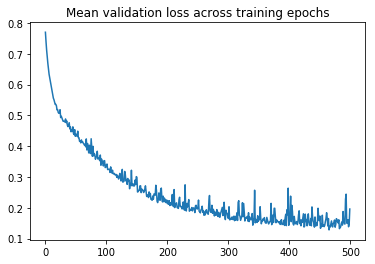

In [61]:
###Plot the loss history###
plt.title("Mean validation loss across training epochs")
plt.plot(range(len(loss_history)),loss_history)

INFO:tensorflow:Restoring parameters from working_data/saved_models/lenet_local/lenet_local.ckpt


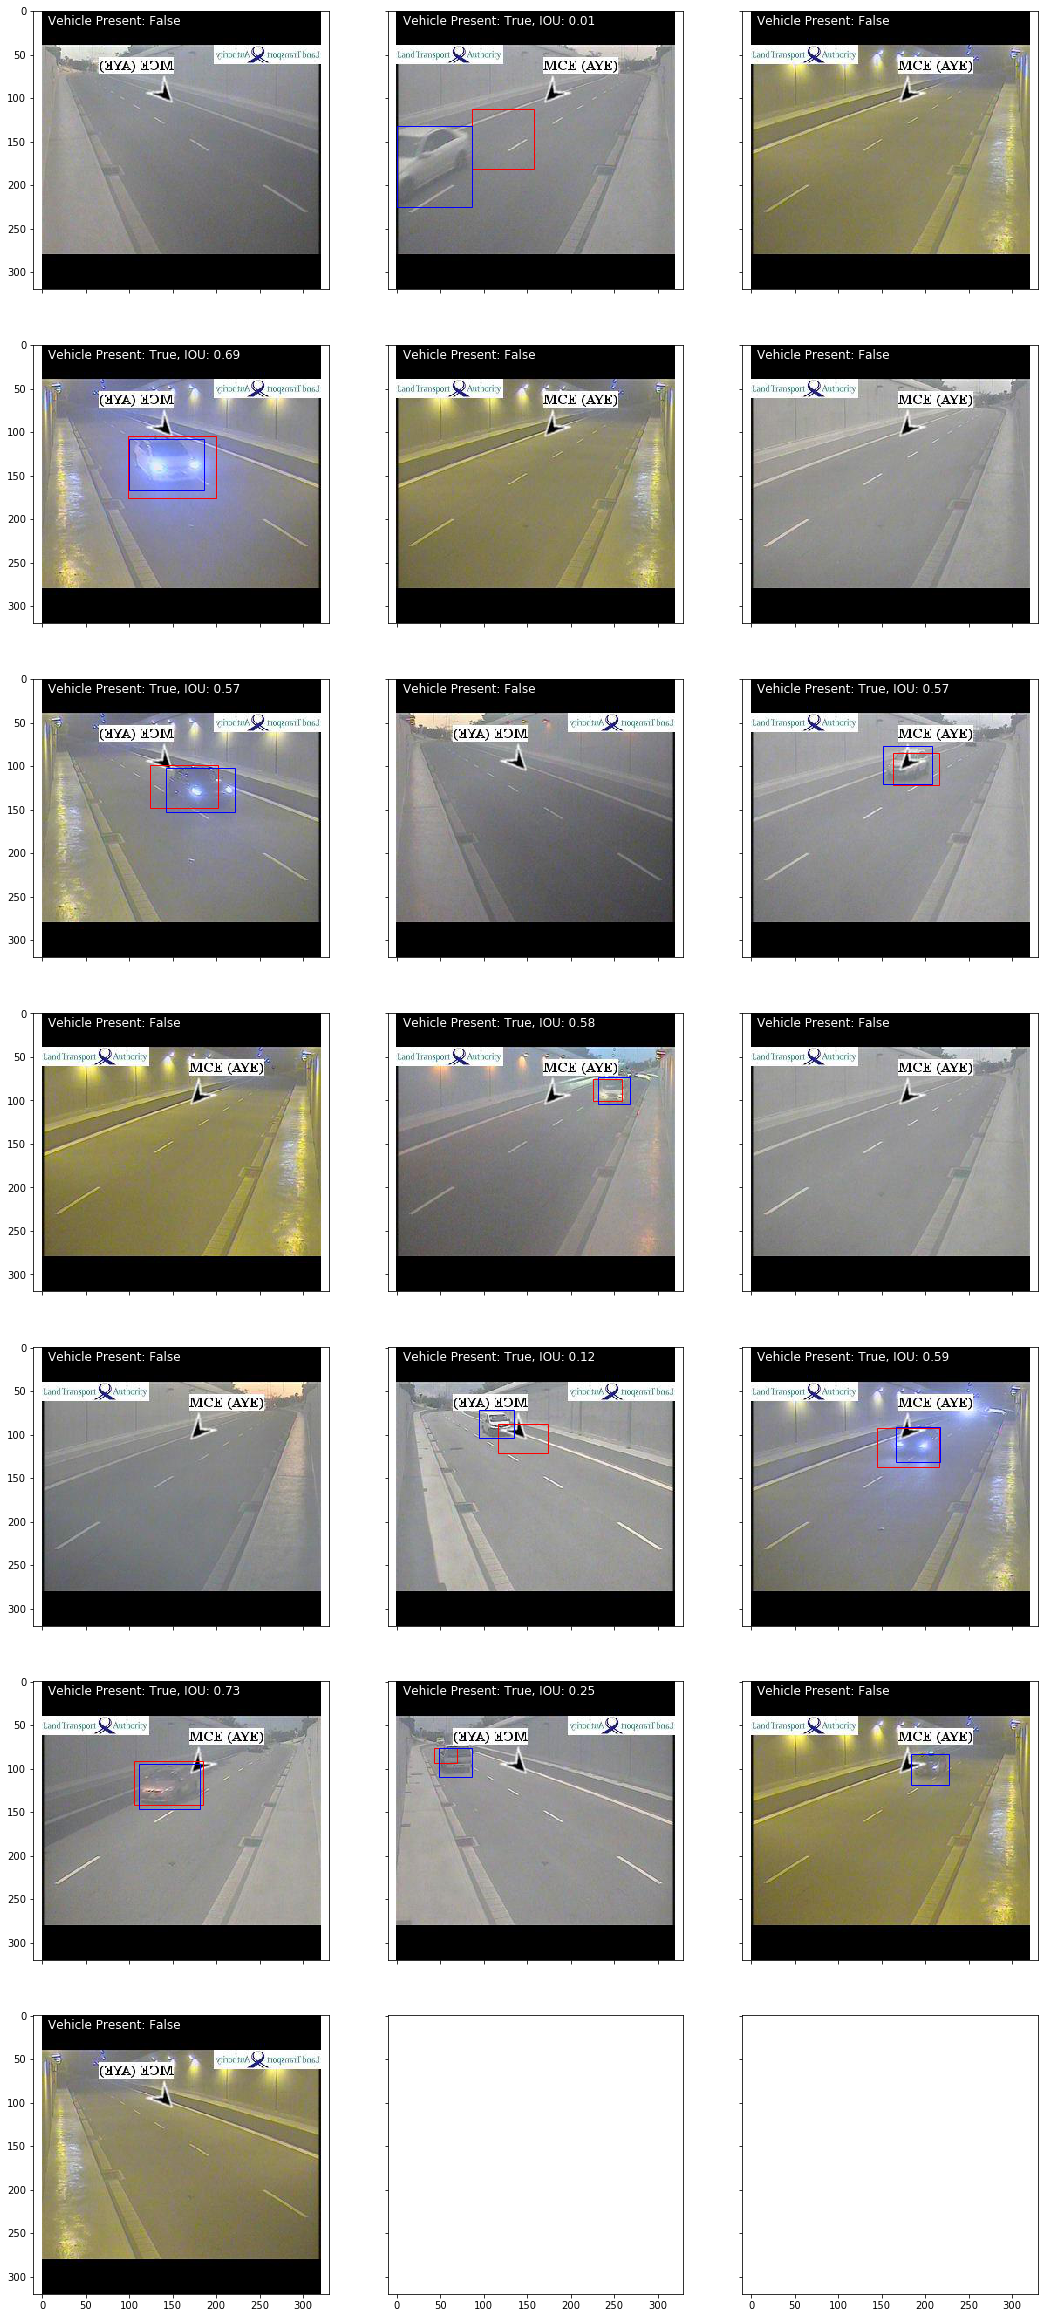

In [62]:
with tf.Session(graph=graph_lenet_local) as sess:
    saver.restore(sess, save_path+"/lenet_local.ckpt")
    coords = val_coords.eval()
    p_labels = val_pred_labels.eval()
    plot_traffic(val_data[0:19],coords[0:19],p_label=p_labels[0:19],plot_gt=True,gt_bb=val_reg_labels[0:19],gt_label=val_labels[0:19,0])

In [90]:
##VGG16 by Visual Geometry Group, Oxford

###Parameters for VGG16###
train_epochs = 500
image_size = 320
num_channels = 3
num_reg_labels = 4
num_labels = 2
batch_size=30
conv_size=3
conv_stride=3
pool_size = 2
pool_stride = 2
depth_1=64
depth_2=128
depth_3=256
depth_4=512
depth_5=512
num_hidden_1=4096
num_hidden_2=4096
learning_rate = 1e-5
keep_prob = 0.5
regular_strength = 5e-4
#######################

graph_vgg16_local = tf.Graph()

with graph_vgg16_local.as_default():
    #set up variables/placeholders for tensorflow graph
    with tf.variable_scope("train_input"):
        tf_train_data = tf.placeholder(tf.float32, shape=(batch_size,image_size,image_size,num_channels),name="image_data")
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size,num_labels),name="class_labels")
        tf_train_reg_labels = tf.placeholder(tf.float32, shape=(batch_size,num_reg_labels),name="bb_labels")
        lr = tf.placeholder(tf.float32,name="learning_rate")
        
    with tf.variable_scope("val_input"):
        tf_val_data = tf.constant(val_data)
        tf_val_labels = tf.constant(hot_val_labels)
        tf_val_reg_labels = tf.constant(val_reg_labels)
    
    def model(data,name,train=True):
        with tf.variable_scope(name):
            conv1 = conv2d_relu(data,conv_stride,conv_size,depth_1,name="CONV1",train=train)
            conv2 = conv2d_relu(conv1,conv_stride,conv_size,depth_1,name="CONV2",train=train)
            pool1 = max_pool(conv2,pool_size,pool_stride,name="POOL1")
            conv3 = conv2d_relu(pool1,conv_stride,conv_size,depth_2,name="CONV3",train=train)
            conv4 = conv2d_relu(conv3,conv_stride,conv_size,depth_2,name="CONV4",train=train)
            pool2 = max_pool(conv4,pool_size,pool_stride,name="POOL2")
            conv5 = conv2d_relu(pool2,conv_stride,conv_size,depth_3,name="CONV5",train=train)
            conv6 = conv2d_relu(conv5,conv_stride,conv_size,depth_3,name="CONV6",train=train)
            conv7 = conv2d_relu(conv6,conv_stride,conv_size,depth_3,name="CONV7",train=train)
            #conv8 = conv2d_relu(conv7,conv_stride,conv_size,depth_3,name="CONV8",train=train)
            pool3 = max_pool(conv7,pool_size,pool_stride,name="POOL3")
            conv9 = conv2d_relu(pool3,conv_stride,conv_size,depth_4,name="CONV9",train=train)
            conv10 = conv2d_relu(conv9,conv_stride,conv_size,depth_4,name="CONV10",train=train)
            conv11 = conv2d_relu(conv10,conv_stride,conv_size,depth_4,name="CONV11",train=train)
            #conv12 = conv2d_relu(conv11,conv_stride,conv_size,depth_4,name="CONV12",train=train)
            pool4 = max_pool(conv11,pool_size,pool_stride,name="POOL4")
            conv13 = conv2d_relu(pool4,conv_stride,conv_size,depth_5,name="CONV13",train=train)
            conv14 = conv2d_relu(conv13,conv_stride,conv_size,depth_5,name="CONV14",train=train)
            conv15 = conv2d_relu(conv14,conv_stride,conv_size,depth_5,name="CONV15",train=train)
            #conv16 = conv2d_relu(conv15,conv_stride,conv_size,depth_5,name="CONV16",train=train)
            pool5 = max_pool(conv15,pool_size,pool_stride,name="POOL5")
            ##Implement dropout on the fully connected layers
            if train:
                fc1_class = tf.nn.dropout(fully_connected(pool5,num_hidden_1,name="FC1_class",train=train,xv=False),keep_prob)
                fc2_class = tf.nn.dropout(fully_connected(fc1_class,num_hidden_2,name="FC2_class",train=train),keep_prob)
                fc1_reg = tf.nn.dropout(fully_connected(pool5,num_hidden_1,name="FC1_reg",train=train,xv=False),keep_prob)
            else:
                fc1_class = fully_connected(pool5,num_hidden_1,name="FC1_class",train=train)
                fc2_class = fully_connected(fc1_class,num_hidden_2,name="FC2_class",train=train)
                fc1_reg = fully_connected(pool5,num_hidden_1,name="FC1_reg",train=train)
            ##For stability of training, intentionally exclude dropout on layer before regression output layer
            fc2_reg = fully_connected(fc1_reg,num_hidden_2,name="FC2_reg",train=train)
            ##Calculate outputs for classification and localization
            output_logits = fully_connected(fc2_class,num_labels,name="Output_logits",train=train)
            output_coords = fully_connected(fc2_reg,num_reg_labels,activation=False,name="Output_coords",train=train)
        return output_logits, output_coords
    
    def loss(reg_pred,reg_label,class_logit,class_label,name):
        with tf.variable_scope(name):
            with tf.variable_scope("Regression_Loss"):
                mask = tf.equal(class_label[:,1], tf.ones_like(class_label[:,1]))
                with tf.variable_scope("Coord_Loss"):
                    coord_loss = tf.reduce_mean(tf.reduce_sum(tf.square(tf.boolean_mask(reg_label[:,0:2],mask)-tf.boolean_mask(reg_pred[:,0:2],mask)),1))
                with tf.variable_scope("Box_Loss"):
                    box_loss = tf.reduce_mean(tf.reduce_sum(tf.square(tf.boolean_mask(reg_label[:,2:],mask)-tf.boolean_mask(reg_pred[:,2:],mask)),1))
                regression_loss = coord_loss + box_loss
            with tf.variable_scope("Class_Loss"):
                class_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=class_label,logits=class_logit))
            with tf.variable_scope("Regularization_Loss"):
                g = tf.get_default_graph()
                regular_loss = (tf.nn.l2_loss(g.get_tensor_by_name("Train_Model/FC1_class/weights:0"))+ 
                                tf.nn.l2_loss(g.get_tensor_by_name("Train_Model/FC2_class/weights:0"))+
                                tf.nn.l2_loss(g.get_tensor_by_name("Train_Model/Output_logits/weights:0"))+
                                tf.nn.l2_loss(g.get_tensor_by_name("Train_Model/FC1_reg/weights:0"))+
                                tf.nn.l2_loss(g.get_tensor_by_name("Train_Model/FC2_reg/weights:0"))+
                                tf.nn.l2_loss(g.get_tensor_by_name("Train_Model/Output_coords/weights:0")))
            loss = class_loss+regression_loss+(regular_strength*regular_loss)
        return loss
    
    train_logits, train_coords = model(tf_train_data,"Train_Model",train=True)
    val_logits, val_coords = model(tf_val_data,"Val_Model",train=False)
        
    train_loss = loss(train_coords,tf_train_reg_labels,train_logits,tf_train_labels,"Train_Loss")
    val_loss = loss(val_coords,tf_val_reg_labels,val_logits,tf_val_labels,"Val_Loss")
    
    with tf.variable_scope("Val_Pred_Labels"):
        val_pred_logits = tf.nn.softmax(val_logits)
        val_pred_labels = tf.argmax(val_pred_logits,axis=1)
    
    with tf.variable_scope("Train"):
        optimizer = tf.train.AdamOptimizer(lr).minimize(train_loss)
        
    with tf.variable_scope("Saver"):
        saver = tf.train.Saver()

0.1
0.0589255650989
0.0589255650989
0.0416666666667
0.0416666666667
0.0294627825494
0.0294627825494
0.0294627825494
0.0208333333333
0.0208333333333
0.0208333333333
0.0208333333333
0.0208333333333
0.01
0.0220970869121
0.01
0.0220970869121
0.0220970869121
0.0220970869121


In [91]:
###Training the VGG16 Model###
save_path = "/home/marcchan/Traffic/traffic_image_detection/working_data/saved_models/vgg16_local"
os.makedirs(save_path,exist_ok=True)
start_time = time.time()

with tf.Session(graph=graph_vgg16_local) as sess:
    writer = tf.summary.FileWriter(save_path, graph=tf.get_default_graph())
    #loss_history = []
    #tf.global_variables_initializer().run()
    saver.restore(sess, save_path+"/vgg16_local.ckpt")
    print("Initialized!")
    num_epochs = 0
    train_switch = True
    while train_switch:
        num_epochs += 1
        t_losses = []
        ##Feed randomized batch for training
        rnd_index = np.random.permutation(train_data.shape[0])
        for x in range(train_data.shape[0]//batch_size):
            feed_dict = {
                tf_train_data: train_data[rnd_index[x*batch_size:(x+1)*batch_size]],
                tf_train_labels: hot_train_labels[rnd_index[x*batch_size:(x+1)*batch_size]],
                tf_train_reg_labels: train_reg_labels[rnd_index[x*batch_size:(x+1)*batch_size]],
                lr: learning_rate
            }
            t_loss, _ = sess.run([train_loss,optimizer],feed_dict=feed_dict)
            t_losses.append(t_loss)
            
        loss = val_loss.eval()
        loss_history.append(loss)
        print("Epoch {}, training loss= {}, validation loss = {}".format(num_epochs,np.mean(t_losses),loss))
        validation_pred = val_pred_logits.eval()
        validation_coords = val_coords.eval()
        metrics(val_labels[:,0],np.array(validation_pred),val_labels[:,1:],np.array(validation_coords))
        
        
        ##Save model every 50 epochs
        if num_epochs%50 == 0:
            saver.save(sess, save_path+"/vgg16_local.ckpt")
            print("Session saved!")
        
        ##Halve learning rate every 100 epochs
        #if num_epochs%100 == 0:
            #learning_rate = learning_rate/2
        
        ###Stopping criteria
        if num_epochs == train_epochs:
            train_switch = False
            
    ##Save trained model for future use
    saved_ckpt = saver.save(sess, save_path+"/vgg16_local.ckpt")

    
print("Stopping criteria met!")
print("Time elasped: {0:.0f} hours {1:.0f} minutes".format((time.time()-start_time)//(60*60),((time.time()-start_time)%(60*60))//60))
print("Checkpoint file saved at {}".format(saved_ckpt))

INFO:tensorflow:Restoring parameters from working_data/saved_models/vgg16_local/vgg16_local.ckpt
Initialized!
Epoch 1, training loss= 0.006745029706507921, validation loss = 0.1383046954870224
IOU: 0.53, Accuracy: 0.97, AUC:1.00, Precision: 0.98, Recall: 0.96
Epoch 2, training loss= 0.006730793975293636, validation loss = 0.13804158568382263
IOU: 0.53, Accuracy: 0.97, AUC:1.00, Precision: 0.98, Recall: 0.96
Epoch 3, training loss= 0.006597868632525206, validation loss = 0.13768668472766876
IOU: 0.53, Accuracy: 0.97, AUC:1.00, Precision: 0.98, Recall: 0.96
Epoch 4, training loss= 0.006695035845041275, validation loss = 0.13756301999092102
IOU: 0.53, Accuracy: 0.97, AUC:1.00, Precision: 0.98, Recall: 0.96
Epoch 5, training loss= 0.0065233949571847916, validation loss = 0.13688981533050537
IOU: 0.53, Accuracy: 0.97, AUC:1.00, Precision: 0.98, Recall: 0.96
Epoch 6, training loss= 0.006528023164719343, validation loss = 0.13725772500038147
IOU: 0.53, Accuracy: 0.97, AUC:1.00, Precision: 0.9

Epoch 55, training loss= 0.004963322542607784, validation loss = 0.1390623152256012
IOU: 0.53, Accuracy: 0.97, AUC:1.00, Precision: 0.98, Recall: 0.96
Epoch 56, training loss= 0.005013239104300737, validation loss = 0.13841208815574646
IOU: 0.53, Accuracy: 0.97, AUC:1.00, Precision: 0.98, Recall: 0.96
Epoch 57, training loss= 0.004957155790179968, validation loss = 0.13661067187786102
IOU: 0.53, Accuracy: 0.97, AUC:1.00, Precision: 0.98, Recall: 0.96
Epoch 58, training loss= 0.004839139524847269, validation loss = 0.1367412656545639
IOU: 0.54, Accuracy: 0.97, AUC:1.00, Precision: 0.98, Recall: 0.96
Epoch 59, training loss= 0.0048295073211193085, validation loss = 0.13735787570476532
IOU: 0.53, Accuracy: 0.97, AUC:1.00, Precision: 0.98, Recall: 0.96
Epoch 60, training loss= 0.00482343602925539, validation loss = 0.13744491338729858
IOU: 0.54, Accuracy: 0.97, AUC:1.00, Precision: 0.98, Recall: 0.96
Epoch 61, training loss= 0.004823233932256699, validation loss = 0.1369757503271103
IOU: 0

Epoch 109, training loss= 0.003482520580291748, validation loss = 0.14513936638832092
IOU: 0.54, Accuracy: 0.97, AUC:1.00, Precision: 0.98, Recall: 0.97
Epoch 110, training loss= 0.0035385731607675552, validation loss = 0.14659924805164337
IOU: 0.54, Accuracy: 0.97, AUC:1.00, Precision: 0.98, Recall: 0.97
Epoch 111, training loss= 0.0034889678936451674, validation loss = 0.1490803360939026
IOU: 0.53, Accuracy: 0.97, AUC:1.00, Precision: 0.98, Recall: 0.97
Epoch 112, training loss= 0.0034109370317310095, validation loss = 0.14828303456306458
IOU: 0.54, Accuracy: 0.97, AUC:1.00, Precision: 0.98, Recall: 0.97
Epoch 113, training loss= 0.0034829149954020977, validation loss = 0.14818818867206573
IOU: 0.54, Accuracy: 0.97, AUC:1.00, Precision: 0.98, Recall: 0.97
Epoch 114, training loss= 0.0033793020993471146, validation loss = 0.14763396978378296
IOU: 0.53, Accuracy: 0.97, AUC:1.00, Precision: 0.98, Recall: 0.97
Epoch 115, training loss= 0.0033866434823721647, validation loss = 0.147193104

Epoch 163, training loss= 0.002736511640250683, validation loss = 0.15278252959251404
IOU: 0.53, Accuracy: 0.98, AUC:1.00, Precision: 0.98, Recall: 0.97
Epoch 164, training loss= 0.0027292303275316954, validation loss = 0.1497383564710617
IOU: 0.54, Accuracy: 0.98, AUC:1.00, Precision: 0.98, Recall: 0.97
Epoch 165, training loss= 0.0026620994322001934, validation loss = 0.15099675953388214
IOU: 0.54, Accuracy: 0.98, AUC:1.00, Precision: 0.98, Recall: 0.97
Epoch 166, training loss= 0.002679556142538786, validation loss = 0.15116019546985626
IOU: 0.54, Accuracy: 0.98, AUC:1.00, Precision: 0.98, Recall: 0.97
Epoch 167, training loss= 0.0026535987854003906, validation loss = 0.15329742431640625
IOU: 0.54, Accuracy: 0.98, AUC:1.00, Precision: 0.98, Recall: 0.97
Epoch 168, training loss= 0.002640453167259693, validation loss = 0.15601970255374908
IOU: 0.54, Accuracy: 0.98, AUC:1.00, Precision: 0.98, Recall: 0.97
Epoch 169, training loss= 0.0026409965939819813, validation loss = 0.15026439726

Epoch 217, training loss= 0.0022676107473671436, validation loss = 0.14828455448150635
IOU: 0.54, Accuracy: 0.98, AUC:1.00, Precision: 0.98, Recall: 0.97
Epoch 218, training loss= 0.0022713029757142067, validation loss = 0.1522643268108368
IOU: 0.54, Accuracy: 0.98, AUC:1.00, Precision: 0.98, Recall: 0.97
Epoch 219, training loss= 0.0022506890818476677, validation loss = 0.14667388796806335
IOU: 0.54, Accuracy: 0.98, AUC:1.00, Precision: 0.98, Recall: 0.97
Epoch 220, training loss= 0.0022510008420795202, validation loss = 0.14439092576503754
IOU: 0.54, Accuracy: 0.98, AUC:1.00, Precision: 0.98, Recall: 0.97
Epoch 221, training loss= 0.0022025154903531075, validation loss = 0.14728513360023499
IOU: 0.54, Accuracy: 0.98, AUC:1.00, Precision: 0.98, Recall: 0.97
Epoch 222, training loss= 0.002229895442724228, validation loss = 0.14846789836883545
IOU: 0.53, Accuracy: 0.98, AUC:1.00, Precision: 0.98, Recall: 0.97
Epoch 223, training loss= 0.0022527556866407394, validation loss = 0.140559121

Epoch 271, training loss= 0.0019552409648895264, validation loss = 0.17262855172157288
IOU: 0.54, Accuracy: 0.98, AUC:1.00, Precision: 0.99, Recall: 0.97
Epoch 272, training loss= 0.002036013640463352, validation loss = 0.17869724333286285
IOU: 0.55, Accuracy: 0.97, AUC:1.00, Precision: 0.99, Recall: 0.96
Epoch 273, training loss= 0.0019672841299325228, validation loss = 0.17710185050964355
IOU: 0.55, Accuracy: 0.97, AUC:1.00, Precision: 0.99, Recall: 0.95
Epoch 274, training loss= 0.001994926482439041, validation loss = 0.18196436762809753
IOU: 0.55, Accuracy: 0.97, AUC:1.00, Precision: 0.99, Recall: 0.96
Epoch 275, training loss= 0.0020300124306231737, validation loss = 0.17619474232196808
IOU: 0.55, Accuracy: 0.98, AUC:1.00, Precision: 0.99, Recall: 0.96
Epoch 276, training loss= 0.0019755344837903976, validation loss = 0.17283448576927185
IOU: 0.55, Accuracy: 0.98, AUC:1.00, Precision: 0.99, Recall: 0.97
Epoch 277, training loss= 0.001932067098096013, validation loss = 0.1782189011

Epoch 325, training loss= 0.0018766088178381324, validation loss = 0.25297704339027405
IOU: 0.56, Accuracy: 0.97, AUC:1.00, Precision: 0.99, Recall: 0.95
Epoch 326, training loss= 0.0019149642903357744, validation loss = 0.26066938042640686
IOU: 0.55, Accuracy: 0.97, AUC:1.00, Precision: 0.99, Recall: 0.95
Epoch 327, training loss= 0.001827098662033677, validation loss = 0.26697078347206116
IOU: 0.55, Accuracy: 0.97, AUC:1.00, Precision: 0.99, Recall: 0.95
Epoch 328, training loss= 0.0018025103490799665, validation loss = 0.27171334624290466
IOU: 0.55, Accuracy: 0.97, AUC:1.00, Precision: 0.99, Recall: 0.95
Epoch 329, training loss= 0.0018643479561433196, validation loss = 0.27522000670433044
IOU: 0.55, Accuracy: 0.97, AUC:1.00, Precision: 0.99, Recall: 0.95
Epoch 330, training loss= 0.0018405914306640625, validation loss = 0.2684142291545868
IOU: 0.55, Accuracy: 0.97, AUC:1.00, Precision: 0.99, Recall: 0.95
Epoch 331, training loss= 0.0018117916770279408, validation loss = 0.273057907

Epoch 379, training loss= 0.0017385672545060515, validation loss = 0.2210753709077835
IOU: 0.55, Accuracy: 0.97, AUC:1.00, Precision: 0.99, Recall: 0.96
Epoch 380, training loss= 0.0017076736548915505, validation loss = 0.22748979926109314
IOU: 0.55, Accuracy: 0.98, AUC:1.00, Precision: 0.99, Recall: 0.96
Epoch 381, training loss= 0.0017037210054695606, validation loss = 0.23145727813243866
IOU: 0.55, Accuracy: 0.97, AUC:1.00, Precision: 0.99, Recall: 0.96
Epoch 382, training loss= 0.0017221916932612658, validation loss = 0.2353181540966034
IOU: 0.54, Accuracy: 0.98, AUC:1.00, Precision: 0.99, Recall: 0.96
Epoch 383, training loss= 0.0017654991243034601, validation loss = 0.22342179715633392
IOU: 0.54, Accuracy: 0.98, AUC:1.00, Precision: 0.99, Recall: 0.96
Epoch 384, training loss= 0.0017654572147876024, validation loss = 0.22318005561828613
IOU: 0.55, Accuracy: 0.97, AUC:1.00, Precision: 0.99, Recall: 0.96
Epoch 385, training loss= 0.0017699551535770297, validation loss = 0.238479867

Epoch 433, training loss= 0.0016824949998408556, validation loss = 0.2733916640281677
IOU: 0.55, Accuracy: 0.98, AUC:1.00, Precision: 0.99, Recall: 0.96
Epoch 434, training loss= 0.0016358813736587763, validation loss = 0.2639915645122528
IOU: 0.53, Accuracy: 0.98, AUC:1.00, Precision: 0.99, Recall: 0.96
Epoch 435, training loss= 0.0017402394441887736, validation loss = 0.29379427433013916
IOU: 0.55, Accuracy: 0.98, AUC:1.00, Precision: 0.99, Recall: 0.96
Epoch 436, training loss= 0.001615597284398973, validation loss = 0.28466928005218506
IOU: 0.54, Accuracy: 0.98, AUC:1.00, Precision: 0.99, Recall: 0.96
Epoch 437, training loss= 0.0016389270313084126, validation loss = 0.28682175278663635
IOU: 0.54, Accuracy: 0.98, AUC:1.00, Precision: 0.99, Recall: 0.96
Epoch 438, training loss= 0.0016101875808089972, validation loss = 0.29318946599960327
IOU: 0.55, Accuracy: 0.98, AUC:1.00, Precision: 0.99, Recall: 0.96
Epoch 439, training loss= 0.002051023067906499, validation loss = 0.18199434876

Epoch 487, training loss= 0.0015665494138374925, validation loss = 0.19282075762748718
IOU: 0.53, Accuracy: 0.98, AUC:1.00, Precision: 0.99, Recall: 0.96
Epoch 488, training loss= 0.0015630361158400774, validation loss = 0.191728875041008
IOU: 0.55, Accuracy: 0.98, AUC:1.00, Precision: 0.99, Recall: 0.96
Epoch 489, training loss= 0.0015864928718656301, validation loss = 0.19863086938858032
IOU: 0.54, Accuracy: 0.98, AUC:1.00, Precision: 0.99, Recall: 0.96
Epoch 490, training loss= 0.0014818462077528238, validation loss = 0.200593501329422
IOU: 0.53, Accuracy: 0.98, AUC:1.00, Precision: 0.99, Recall: 0.96
Epoch 491, training loss= 0.0015485272742807865, validation loss = 0.19874301552772522
IOU: 0.54, Accuracy: 0.98, AUC:1.00, Precision: 0.99, Recall: 0.96
Epoch 492, training loss= 0.0014855943154543638, validation loss = 0.19772469997406006
IOU: 0.54, Accuracy: 0.98, AUC:1.00, Precision: 0.99, Recall: 0.96
Epoch 493, training loss= 0.0015086811035871506, validation loss = 0.19415339827

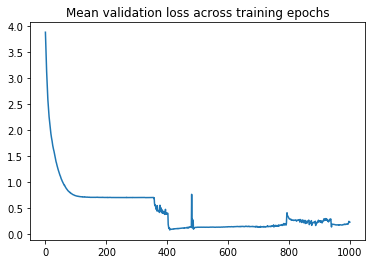

In [92]:
###Plot the loss history###
plt.title("Mean validation loss across training epochs")
plt.plot(range(len(loss_history)),loss_history)

INFO:tensorflow:Restoring parameters from working_data/saved_models/vgg16_local/vgg16_local.ckpt


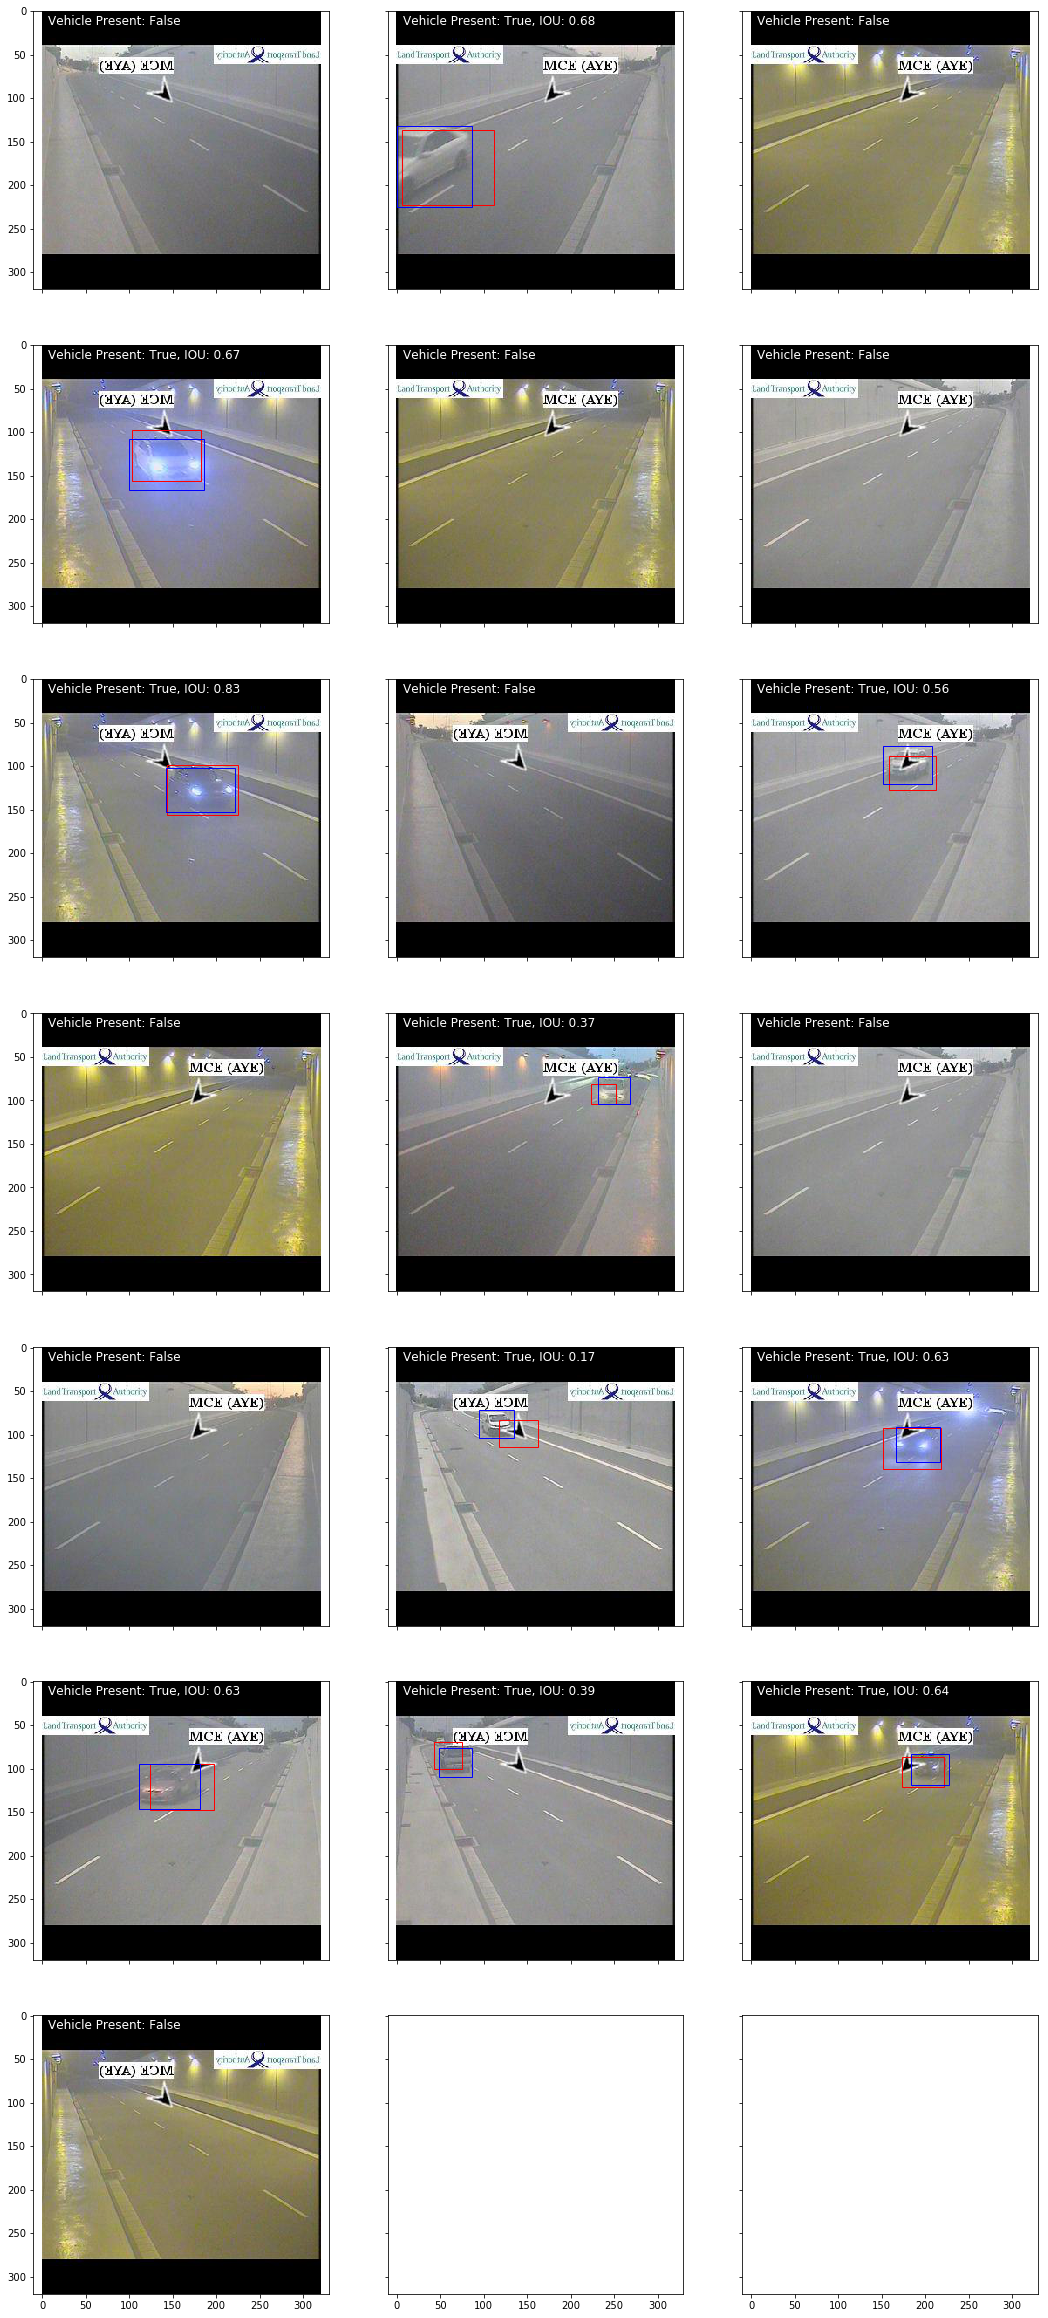

In [94]:
with tf.Session(graph=graph_vgg16_local) as sess:
    saver.restore(sess, save_path+"/vgg16_local.ckpt")
    coords = val_coords.eval()
    p_labels = val_pred_labels.eval()
    plot_traffic(val_data[0:19],coords[0:19],p_label=p_labels[0:19],plot_gt=True,gt_bb=val_reg_labels[0:19],gt_label=val_labels[0:19,0])

### Assessing performance of localization head

In previous classification notebook, assessing performance of a classfier was done via observing the Accuracy, AUC, precision/recall metrics on the validation set.

For the localization problem, we have to use a new metric to assess performance of the classfier, namely Intersection Over Union (IOU). As its name suggests, it is simply the ratio of the intersection and union of the ground truth bounding box vs the predicted bounding box. A perfect score would be = 1.

In [69]:
#Function to implement the IOU metric
def IOU(bounding_true,bounding_pred):
    if bounding_pred.ndim == 1:
        bounding_pred = np.reshape(bounding_pred,[1,-1])
    if bounding_true.ndim == 1:
        bounding_true = np.reshape(bounding_true,[1,-1])
    int_deltaX = np.minimum(bounding_true[:,2],bounding_pred[:,2])-np.maximum(bounding_true[:,0],bounding_pred[:,0])
    int_deltaY = np.minimum(bounding_true[:,3],bounding_pred[:,3])-np.maximum(bounding_true[:,1],bounding_pred[:,1])
    int_area = np.maximum(int_deltaX*int_deltaY,0)
    true_area = (bounding_true[:,2]-bounding_true[:,0])*(bounding_true[:,3]-bounding_true[:,1])
    pred_area = (bounding_pred[:,2]-bounding_pred[:,0])*(bounding_pred[:,3]-bounding_pred[:,1])
    union_area = true_area+pred_area-int_area
    iou = int_area/union_area
    return np.mean(iou)